In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import umap
import numpy as np
from sklearn.preprocessing import minmax_scale
import hdbscan

In [2]:
import base64
from io import BytesIO
from PIL import Image

In [3]:
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import concept

In [5]:
path = '..\\data\\clean\\des_b64_wit_kag_0_of_48.tsv'
df = pd.read_table(path)

In [6]:
images = df['b64_bytes'].apply(lambda x: BytesIO(base64.b64decode(x)))

image_list = images.to_list()

In [7]:
texts = df['context_page_description'].to_list()


In [8]:
interleaved_lists = list(itertools.chain(*zip(texts, image_list)))

# Embeddings

In [9]:
embedding_model = SentenceTransformer("clip-ViT-B-32")

c:\Users\Martin\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [10]:
batch_size = 128
n = len(image_list)

image_embeds = []
for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = image_list[i:i_end]
    images = [Image.open(img) for img in batch]
    batch_embed = embedding_model.encode(images)
    image_embeds.extend(batch_embed.tolist())

text_embeds = []
for i in tqdm(range(0, n, batch_size)):
    i_end = min(i+batch_size, n)
    batch = texts[i:i_end]
    batch_embed = embedding_model.encode(batch)
    text_embeds.extend(batch_embed.tolist())

100%|██████████| 18/18 [00:07<00:00,  2.57it/s]


In [11]:
interleaved_embeddings = list(itertools.chain(*zip(text_embeds, image_embeds)))

In [12]:
normalized_embeddings = minmax_scale(interleaved_embeddings, feature_range=(-1, 1))

In [13]:
added_embeddings = [a+b for a,b in zip(text_embeds, image_embeds)]

In [14]:
normalized_img_embeddings = minmax_scale(image_embeds, feature_range=(-1, 1))
normalized_text_embeddings = minmax_scale(text_embeds, feature_range=(-1, 1))
added_normalized_embeddings = [a+b for a,b in zip(normalized_img_embeddings, normalized_text_embeddings)]

In [15]:
umap_model = umap.UMAP(n_neighbors=5,
                        n_components=5,
                        min_dist=0.1,
                        metric='cosine') # Important that metric is cosine to match clip
# parameters from base concept model

In [16]:
umap_embedding = umap_model.fit_transform(added_embeddings)

In [17]:
hue = []
flipper = True
for i in range(len(umap_embedding)):
    if flipper:
        hue.append('red')
    else:
        hue.append('blue')
    flipper = not flipper

<AxesSubplot:>

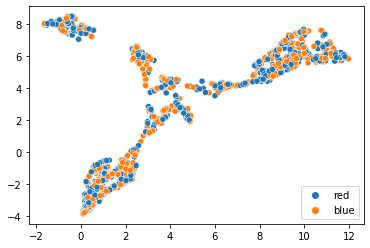

In [18]:

sns.scatterplot(x=umap_embedding[:,0], y=umap_embedding[:,1], hue=hue)

<AxesSubplot:>

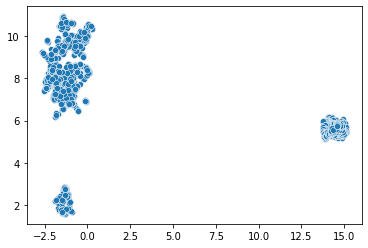

In [19]:
umap_model2 = umap.UMAP(n_neighbors=5,
                        n_components=5,
                        min_dist=0.1,
                        metric='cosine')

umap_embedding2 = umap_model.fit_transform(text_embeds)
sns.scatterplot(x=umap_embedding2[:,0], y=umap_embedding2[:,1])

# Clustering

In [20]:
umap_embed = umap_embedding

In [21]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40)
clusterer.fit(umap_embed)




HDBSCAN(min_cluster_size=40)

<AxesSubplot:ylabel='$\\lambda$ value'>

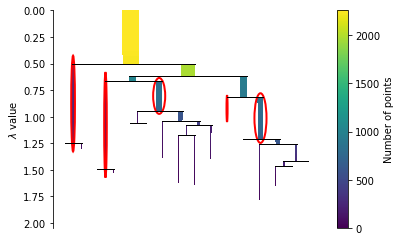

In [22]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [88]:
from hdbscan.flat import HDBSCAN_flat, _new_select_clusters

In [64]:
flat_clusterer = HDBSCAN_flat(umap_embed, clusterer=clusterer, n_clusters=3)

In [66]:
clusterer.labels_[:10]

array([1, 1, 4, 4, 1, 2, 2, 2, 4, 0], dtype=int64)

In [65]:
flat_clusterer.labels_[:10]

array([1, 1, 2, 2, 1, 1, 1, 1, 2, 0], dtype=int64)

<AxesSubplot:ylabel='$\\lambda$ value'>

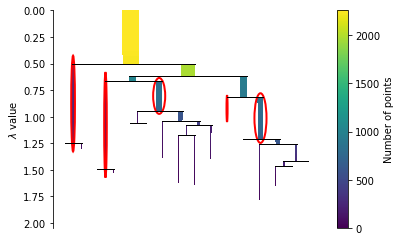

In [67]:
flat_clusterer.condensed_tree_.plot(select_clusters=True)

In [76]:
condensed_tree = flat_clusterer.condensed_tree_
raw_tree = condensed_tree._raw_tree
clusters = sorted(condensed_tree._select_clusters())
cluster_tree = raw_tree[raw_tree['child_size']>1]


In [77]:
cluster_tree

array([(2259, 2260, 0.50139817,  263), (2259, 2261, 0.50139817, 1970),
       (2261, 2262, 0.61587281, 1033), (2261, 2263, 0.61587281,  936),
       (2262, 2264, 0.66397748,  183), (2262, 2265, 0.66397748,  841),
       (2263, 2266, 0.81851862,   75), (2263, 2267, 0.81851862,  841),
       (2264, 2268, 1.49069732,   40), (2264, 2269, 1.49069732,   54),
       (2260, 2270, 1.25193073,   60), (2260, 2271, 1.25193073,   98),
       (2265, 2272, 0.94558776,  131), (2265, 2273, 0.94558776,  616),
       (2272, 2274, 1.06108873,   50), (2272, 2275, 1.06108873,   76),
       (2273, 2276, 1.03752877,  125), (2273, 2277, 1.03752877,  439),
       (2267, 2278, 1.20802998,   68), (2267, 2279, 1.20802998,  633),
       (2277, 2280, 1.07677944,  205), (2277, 2281, 1.07677944,  208),
       (2280, 2282, 1.17259806,   56), (2280, 2283, 1.17259806,  130),
       (2279, 2284, 1.26136681,  181), (2279, 2285, 1.26136681,  401),
       (2285, 2286, 1.41675434,  227), (2285, 2287, 1.41675434,   43),
      

In [74]:
unique_labels = sorted(set(flat_clusterer.labels_))
unique_labels

[-1, 0, 1, 2]

In [90]:
a = _new_select_clusters(condensed_tree, flat_clusterer.cluster_selection_epsilon)

In [92]:
sorted(a)

[2260, 2262, 2263]

In [23]:
import plotly.express as px
palette = ['#1c17ff', '#faff00', '#8cf1ff', '#738FAB', '#030080', '#738fab']

u = umap_embed
colors = [str(x) for x in clusterer.labels_]

fig = px.scatter_3d(
    x=u[:,0], y=u[:,1], z=u[:,2],
    color=colors,
    color_discrete_sequence=palette
)
fig.update_traces(

)

# C-tf-idf

In [24]:
classes = {}
for label in set(clusterer.labels_):
    classes[label] = {
        'vocab': set(),
        'tokens': [],
        'tfidf_array': None
    }
classes

{0: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 1: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 2: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 3: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 4: {'vocab': set(), 'tokens': [], 'tfidf_array': None},
 -1: {'vocab': set(), 'tokens': [], 'tfidf_array': None}}

In [25]:
docs = df['context_page_description'].to_frame()
docs['class'] = clusterer.labels_

In [26]:
import re
import nltk
# first lowercase and remove punctuation
alpha = re.compile(r'[^a-zA-Z ]+')
docs['context_page_description'] = docs['context_page_description'].apply(lambda x: 
    alpha.sub('', x.lower())
)
docs['tokens']=docs['context_page_description'].apply(lambda x: 
    nltk.tokenize.wordpunct_tokenize(x)
)

In [27]:
docs

,context_page_description,class,tokens
0,scolopendra gigantea also known as the peruvia...,1,"[scolopendra, gigantea, also, known, as, the, ..."
1,teucrium corymbosum commonly known as forest g...,1,"[teucrium, corymbosum, commonly, known, as, fo..."
2,the christianpatterson rental property is a tw...,4,"[the, christianpatterson, rental, property, is..."
3,mal thle is a village and municipality in brun...,4,"[mal, thle, is, a, village, and, municipality,..."
4,hymenocallis occidentalis is a plant species n...,1,"[hymenocallis, occidentalis, is, a, plant, spe..."
...,...,...,...
2254,george rawlinson was a british scholar histori...,2,"[george, rawlinson, was, a, british, scholar, ..."
2255,sparta precinct is located in randolph county ...,4,"[sparta, precinct, is, located, in, randolph, ..."
2256,auburn lake trails is a censusdesignated place...,0,"[auburn, lake, trails, is, a, censusdesignated..."
2257,hannah yelland is a britishborn actress now li...,2,"[hannah, yelland, is, a, britishborn, actress,..."


In [28]:
docs.apply(lambda row:
    classes[row['class']]['tokens'].extend(row['tokens']), axis=1
)


0       None
1       None
2       None
3       None
4       None
        ... 
2254    None
2255    None
2256    None
2257    None
2258    None
Length: 2259, dtype: object

In [29]:
nltk.download('stopwords')
for c in classes.keys():
    stopwords = set(nltk.corpus.stopwords.words('english'))
    # stopwords from nltk are all lowercase (so are our tokens)
    classes[c]['tokens'] = [
        word for word in classes[c]['tokens'] if word not in stopwords
    ]
    print(f"{c}: {len(classes[c]['tokens'])}")

0: 6417
1: 4305
2: 21571
3: 2501
4: 21629
-1: 1655


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])


In [31]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = classes[_class]['tokens'].count(term)

100%|██████████| 16220/16220 [00:00<00:00, 45590.99it/s]


In [32]:
idf = np.zeros((1, len(vocab)))

# calculate average number of words per class
A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    # frequency of term t across all classes
    f_t = tf[:,t].sum()
    # calculate IDF
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

100%|██████████| 16220/16220 [00:00<00:00, 199866.07it/s]


In [33]:
tf_idf = tf*idf

In [34]:
n = 5
top_idx = np.argpartition(tf_idf, -n)[:, -n:]
vlist = list(vocab)

for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(_class,topn_terms)

0 ['states', 'united', 'census', 'population', 'county']
1 ['native', 'found', 'genus', 'family', 'species']
2 ['played', 'also', 'professional', 'known', 'american']
3 ['ship', 'uss', 'war', 'built', 'navy']
4 ['district', 'county', 'city', 'station', 'located']
-1 ['bmw', 'produced', 'model', 'car', 'toyota']


# Images

In [35]:
# based on concept: https://github.com/MaartenGr/Concept/tree/c0ab7b0bad4a2fb4003c33d0031f75ab342ef7b9


In [36]:
def _extract_exemplars(clusterer):
    image_nr = [i for i in range(len(clusterer.labels_))]

    # prep condensed tree
    condensed_tree = clusterer.condensed_tree_
    raw_tree = condensed_tree._raw_tree
    clusters = sorted(condensed_tree._select_clusters())
    cluster_tree = raw_tree[raw_tree['child_size']>1]

    # find points with maximum lambda in each leaf
    representative_images = {}
    cluster_labels = sorted(list(set(clusterer.labels_)))
    for cluster in cluster_labels:
        if cluster != -1:
            leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, clusters[cluster])
            exemplars = np.array([])

            for leaf in leaves:
                max_lambda = raw_tree['lambda_val'][raw_tree['parent']==leaf].max()
                points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                            (raw_tree['lambda_val'] == max_lambda)]
                exemplars = np.hstack((exemplars, points))

            representative_images[cluster] = {"Indices": [int(index) for index in exemplars],
                                                "Names": [image_nr[int(index)] for index in exemplars]}

    return representative_images

representative_images = _extract_exemplars(clusterer)



In [37]:
np.array(image_embeds)

array([[ 0.27612305, -0.33129883, -0.16552734, ...,  0.62792969,
        -0.09448242,  0.33374023],
       [-0.31884766,  0.12561035, -0.51025391, ...,  0.30786133,
         0.01325226, -0.24267578],
       [ 0.05953979,  0.22363281, -0.32324219, ...,  0.93554688,
        -0.27124023, -0.07385254],
       ...,
       [ 0.11120605, -0.27197266,  0.19226074, ...,  0.78808594,
         0.07037354, -0.19946289],
       [ 0.45776367, -0.07611084, -0.41967773, ...,  0.08093262,
         0.32788086,  0.10107422],
       [ 0.37841797, -0.19714355, -0.09649658, ...,  0.44287109,
        -0.03967285,  0.05480957]])

In [38]:
def _extract_cluster_embeddings(image_embeddings,
                                    representative_images,
                                    clusterer):
        """ Create a concept cluster embedding for each concept cluster by
        averaging the exemplar embeddings for each concept cluster.
        Arguments:
            image_embeddings: All image embeddings
            representative_images: The representative images per concept cluster
        Updates:
            cluster_embeddings: The embeddings for each concept cluster
        Returns:
            exemplar_embeddings: The embeddings for each exemplar image
        """
        image_embeddings = np.array(image_embeddings)
        exemplar_embeddings = {}
        cluster_embeddings = []
        cluster_labels = sorted(list(set(clusterer.labels_)))
        for label in cluster_labels[1:]:
            embeddings = image_embeddings[np.array([index for index in
                                                    representative_images[label]["Indices"]])]
            cluster_embedding = np.mean(embeddings, axis=0).reshape(1, -1)

            exemplar_embeddings[label] = embeddings
            cluster_embeddings.append(cluster_embedding)

        cluster_embeddings = cluster_embeddings

        return exemplar_embeddings, cluster_embeddings
exemplar_embeddings, cluster_embeddings = _extract_cluster_embeddings(image_embeds,
                                                        representative_images, clusterer)

In [39]:
def _extract_exemplar_subset(exemplar_embeddings,
                            representative_images,
                            cluster_embeddings,
                            clusterer, diversity=0.3):
        """ Use MMR to filter out images in the exemplar set
        Arguments:
            exemplar_embeddings: The embeddings for each exemplar image
            representative_images: The representative images per concept cluster
        Returns:
            selected_exemplars: A selection (8) of exemplar images for each concept cluster
        """
        cluster_labels = sorted(list(set(clusterer.labels_)))
        selected_exemplars = {cluster: concept._mmr.mmr(cluster_embeddings[cluster],
                                           exemplar_embeddings[cluster],
                                           representative_images[cluster]["Indices"],
                                           diversity=diversity,
                                           top_n=9)
                              for index, cluster in enumerate(cluster_labels[1:])}

        return selected_exemplars

selected_exemplars = _extract_exemplar_subset(exemplar_embeddings,
                                                    representative_images,
                                                    cluster_embeddings, clusterer)

In [40]:
selected_exemplars

{0: [755, 405, 260, 1706, 937, 323, 715, 727, 185],
 1: [1866, 897, 264, 2212, 347, 2171, 24, 876, 1681],
 2: [1895, 1303, 339, 1218, 1883, 557, 1784, 1284, 1733],
 3: [418, 938, 141, 59, 1367, 786, 108, 671, 598],
 4: [1453, 1823, 1186, 1407, 1573, 1808, 1377, 1221, 1781]}

In [41]:
def _cluster_representation(images,
                            selected_exemplars,
                            clusterer):
        """ Cluster exemplars into a single image per concept cluster
        Arguments:
            images: A list of paths to each image
            selected_exemplars: A selection of exemplar images for each concept cluster
        """
        # Find indices of exemplars per cluster
        cluster_labels = sorted(list(set(clusterer.labels_)))
        sliced_exemplars = {cluster: [[j for j in selected_exemplars[cluster][i:i + 3]]
                                      for i in range(0, len(selected_exemplars[cluster]), 3)]
                            for cluster in cluster_labels[1:]}
        
        # combine exemplars into a single image
        cluster_images = {}
        for cluster in cluster_labels[1:]:
            images_to_cluster = [[Image.open(images[index]) for index in sub_indices] for sub_indices in sliced_exemplars[cluster]]
            cluster_image = concept._visualization.get_concat_tile_resize(images_to_cluster)
            cluster_images[cluster] = cluster_image

            # Make sure to properly close images
            '''
            for image_list in images_to_cluster:
                for image in image_list:
                    image.close()
            '''

        return cluster_images
cluster_images = _cluster_representation(image_list, selected_exemplars, clusterer)

In [42]:
cluster_images

{0: <PIL.Image.Image image mode=RGB size=200x200 at 0x14E63A5BAC0>,
 1: <PIL.Image.Image image mode=RGB size=200x200 at 0x14E659FC490>,
 2: <PIL.Image.Image image mode=RGB size=200x200 at 0x14E65A90790>,
 3: <PIL.Image.Image image mode=RGB size=200x200 at 0x14E659FC2E0>,
 4: <PIL.Image.Image image mode=RGB size=200x200 at 0x14E659FC070>}

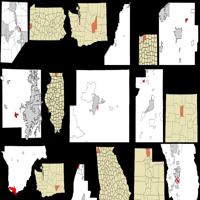

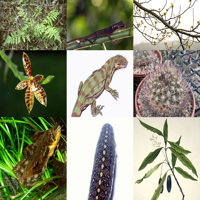

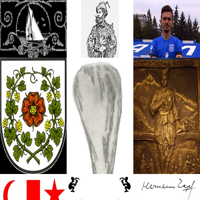

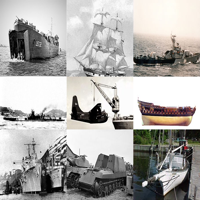

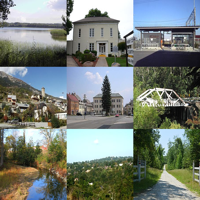

In [43]:
display(*cluster_images.values())